<a href="https://colab.research.google.com/github/vikpy/DLSem3/blob/master/Lec_on_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
# Step get the dataset 
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df.head()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [7]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [9]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

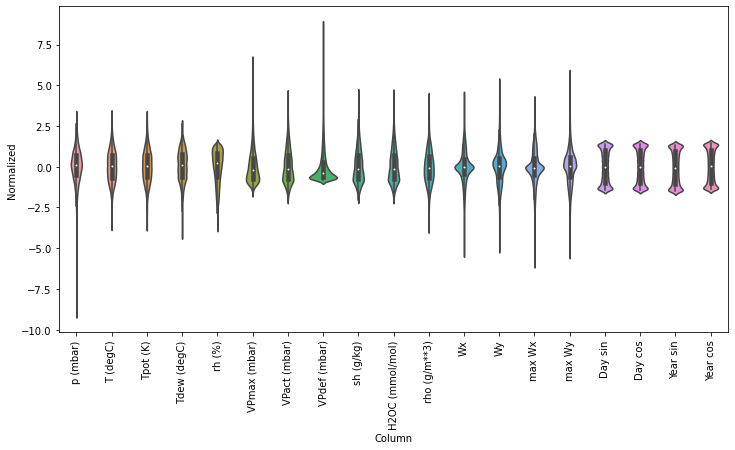

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [15]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [29]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

#RNN

In [30]:
val_performance = {}
performance = {}

In [34]:
simple_rnn = tf.keras.models.Sequential([
         tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
         tf.keras.layers.Dense(units=1)                                
]
    
)
simple_rnn.compile(loss="mean_squared_error", optimizer = "adam",
                   metrics=["mean_absolute_error"]
                   )

history = simple_rnn.fit(single_step_window.train, epochs=10,\
                         validation_data=single_step_window.val)


Epoch 1/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0396 - mean_absolute_error: 0.1189 - val_loss: 0.0098 - val_mean_absolute_error: 0.0737
Epoch 2/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0694 - val_loss: 0.0084 - val_mean_absolute_error: 0.0663
Epoch 3/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0082 - mean_absolute_error: 0.0657 - val_loss: 0.0077 - val_mean_absolute_error: 0.0642
Epoch 4/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0076 - val_mean_absolute_error: 0.0631
Epoch 5/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0077 - mean_absolute_error: 0.0633 - val_loss: 0.0075 - val_mean_absolute_error: 0.0630
Epoch 6/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0623 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615
Epoc

In [35]:
val_performance['simple rnn'] = simple_rnn.evaluate(single_step_window.val)
performance['simple rnn'] = simple_rnn.evaluate(single_step_window.test)

220/220 [==============================] - 1s 3ms/step - loss: 0.0070 - mean_absolute_error: 0.0612


In [37]:
simple_rnn = tf.keras.models.Sequential([
         tf.keras.layers.LSTM(units=32, return_sequences=True),
         tf.keras.layers.Dense(units=1)                                
]
    
)
simple_rnn.compile(loss="mean_squared_error", optimizer = "adam",
                   metrics=["mean_absolute_error"]
                   )

history = simple_rnn.fit(single_step_window.train, epochs=10,\
                         validation_data=single_step_window.val)


Epoch 1/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0223 - mean_absolute_error: 0.0850 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621
Epoch 2/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0612 - val_loss: 0.0069 - val_mean_absolute_error: 0.0598
Epoch 3/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0602 - val_loss: 0.0071 - val_mean_absolute_error: 0.0608
Epoch 4/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0591 - val_loss: 0.0065 - val_mean_absolute_error: 0.0579
Epoch 5/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0587 - val_loss: 0.0066 - val_mean_absolute_error: 0.0581
Epoch 6/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0068 - mean_absolute_error: 0.0582 - val_loss: 0.0065 - val_mean_absolute_error: 0.0574
Epoc

# Wide Window 

In [41]:
val_performance ={}
performance = {}

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [44]:
simple_gru = tf.keras.models.Sequential([
                               tf.keras.layers.GRU(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_gru.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_gru.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple gru'] = simple_gru.evaluate(wide_window.val)
performance['simple gru'] = simple_gru.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0125 - mean_absolute_error: 0.0723 - val_loss: 0.0063 - val_mean_absolute_error: 0.0557
Epoch 2/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0063 - mean_absolute_error: 0.0556 - val_loss: 0.0059 - val_mean_absolute_error: 0.0535
Epoch 3/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0539 - val_loss: 0.0057 - val_mean_absolute_error: 0.0525
Epoch 4/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0529 - val_loss: 0.0058 - val_mean_absolute_error: 0.0530
Epoch 5/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0057 - mean_absolute_error: 0.0523 - val_loss: 0.0056 - val_mean_absolute_error: 0.0515
Epoch 6/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0517 - val_loss: 0.0056 - val_mean_absolute_error:

In [45]:
simple_gru.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 32)            5088      
_________________________________________________________________
dense_14 (Dense)             (None, 24, 1)             33        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [46]:
simple_lstm = tf.keras.models.Sequential([
                               tf.keras.layers.LSTM(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_lstm.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple lstm'] = simple_lstm.evaluate(wide_window.val)
performance['simple lstm'] = simple_lstm.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0273 - mean_absolute_error: 0.0915 - val_loss: 0.0065 - val_mean_absolute_error: 0.0569
Epoch 2/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0064 - mean_absolute_error: 0.0558 - val_loss: 0.0059 - val_mean_absolute_error: 0.0535
Epoch 3/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0060 - mean_absolute_error: 0.0537 - val_loss: 0.0058 - val_mean_absolute_error: 0.0530
Epoch 4/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0526 - val_loss: 0.0058 - val_mean_absolute_error: 0.0526
Epoch 5/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0519 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 6/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0513 - val_loss: 0.0056 - val_mean_absolute_error:

In [47]:
simple_rnn = tf.keras.models.Sequential([
                               tf.keras.layers.LSTM(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=1)   
])

simple_rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_rnn.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple rnn'] = simple_lstm.evaluate(wide_window.val)
performance['simple rnn'] = simple_lstm.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0182 - mean_absolute_error: 0.0821 - val_loss: 0.0064 - val_mean_absolute_error: 0.0564
Epoch 2/10
1533/1533 [==============================] - 21s 13ms/step - loss: 0.0062 - mean_absolute_error: 0.0551 - val_loss: 0.0059 - val_mean_absolute_error: 0.0536
Epoch 3/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0059 - mean_absolute_error: 0.0532 - val_loss: 0.0057 - val_mean_absolute_error: 0.0526
Epoch 4/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0524 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 5/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0518 - val_loss: 0.0056 - val_mean_absolute_error: 0.0514
Epoch 6/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0513 - val_loss: 0.0056 - val_mean_absolute_error:

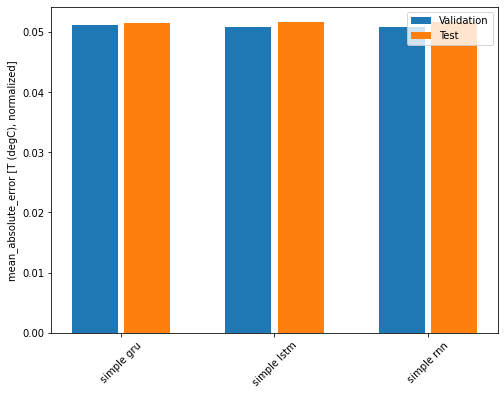

In [48]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = simple_rnn.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [49]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

In [51]:
num_features

19

In [50]:
simple_rnn = tf.keras.models.Sequential([
                               tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_rnn.fit(single_step_window.train, epochs=10, validation_data=single_step_window.val)

val_performance['simple rnn'] = simple_rnn.evaluate(single_step_window.val)
performance['simple rnn'] = simple_rnn.evaluate(single_step_window.test)

Epoch 1/10
1534/1534 [==============================] - 7s 4ms/step - loss: 0.1375 - mean_absolute_error: 0.2217 - val_loss: 0.0784 - val_mean_absolute_error: 0.1560
Epoch 2/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0763 - mean_absolute_error: 0.1492 - val_loss: 0.0744 - val_mean_absolute_error: 0.1441
Epoch 3/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0740 - mean_absolute_error: 0.1428 - val_loss: 0.0729 - val_mean_absolute_error: 0.1400
Epoch 4/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0730 - mean_absolute_error: 0.1398 - val_loss: 0.0722 - val_mean_absolute_error: 0.1374
Epoch 5/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0723 - mean_absolute_error: 0.1379 - val_loss: 0.0717 - val_mean_absolute_error: 0.1366
Epoch 6/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0719 - mean_absolute_error: 0.1366 - val_loss: 0.0713 - val_mean_absolute_error: 0.1345
Epoc

In [52]:
simple_lstm = tf.keras.models.Sequential([
                               tf.keras.layers.LSTM(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_lstm.fit(single_step_window.train, epochs=10, validation_data=single_step_window.val)

val_performance['simple lstm'] = simple_lstm.evaluate(single_step_window.val)
performance['simple lstm'] = simple_lstm.evaluate(single_step_window.test)

Epoch 1/10
1534/1534 [==============================] - 8s 5ms/step - loss: 0.1730 - mean_absolute_error: 0.2625 - val_loss: 0.0805 - val_mean_absolute_error: 0.1659
Epoch 2/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0762 - mean_absolute_error: 0.1546 - val_loss: 0.0732 - val_mean_absolute_error: 0.1465
Epoch 3/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0725 - mean_absolute_error: 0.1438 - val_loss: 0.0714 - val_mean_absolute_error: 0.1412
Epoch 4/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0713 - mean_absolute_error: 0.1395 - val_loss: 0.0704 - val_mean_absolute_error: 0.1381
Epoch 5/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0705 - mean_absolute_error: 0.1370 - val_loss: 0.0698 - val_mean_absolute_error: 0.1353
Epoch 6/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0702 - mean_absolute_error: 0.1356 - val_loss: 0.0694 - val_mean_absolute_error: 0.1343
Epoc

In [54]:
simple_gru = tf.keras.models.Sequential([
                               tf.keras.layers.GRU(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_gru.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_gru.fit(single_step_window.train, epochs=10, validation_data=single_step_window.val)

val_performance['simple gru'] = simple_gru.evaluate(single_step_window.val)
performance['simple gru'] = simple_lstm.evaluate(single_step_window.test)

Epoch 1/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.1343 - mean_absolute_error: 0.2186 - val_loss: 0.0743 - val_mean_absolute_error: 0.1482
Epoch 2/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0733 - mean_absolute_error: 0.1445 - val_loss: 0.0713 - val_mean_absolute_error: 0.1391
Epoch 3/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0716 - mean_absolute_error: 0.1388 - val_loss: 0.0706 - val_mean_absolute_error: 0.1359
Epoch 4/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0708 - mean_absolute_error: 0.1361 - val_loss: 0.0698 - val_mean_absolute_error: 0.1335
Epoch 5/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0702 - mean_absolute_error: 0.1341 - val_loss: 0.0695 - val_mean_absolute_error: 0.1316
Epoch 6/10
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0698 - mean_absolute_error: 0.1329 - val_loss: 0.0688 - val_mean_absolute_error: 0.1309
Epoc

In [55]:
single_step_window.train

<MapDataset shapes: ((None, 1, 19), (None, 1, 19)), types: (tf.float32, tf.float32)>

In [56]:
# Wide Window multiple output
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

In [57]:
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): None

In [59]:
simple_rnn = tf.keras.models.Sequential([
                               tf.keras.layers.SimpleRNN(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_rnn.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_rnn.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple rnn'] = simple_rnn.evaluate(wide_window.val)
performance['simple rnn'] = simple_rnn.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1338 - mean_absolute_error: 0.2180 - val_loss: 0.0716 - val_mean_absolute_error: 0.1442
Epoch 2/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0698 - mean_absolute_error: 0.1390 - val_loss: 0.0675 - val_mean_absolute_error: 0.1335
Epoch 3/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0674 - mean_absolute_error: 0.1325 - val_loss: 0.0659 - val_mean_absolute_error: 0.1295
Epoch 4/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0663 - mean_absolute_error: 0.1295 - val_loss: 0.0653 - val_mean_absolute_error: 0.1279
Epoch 5/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0656 - mean_absolute_error: 0.1278 - val_loss: 0.0647 - val_mean_absolute_error: 0.1262
Epoch 6/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0651 - mean_absolute_error: 0.1266 - val_loss: 0.0642 - val_mean_absolute_error: 0.125

In [60]:
simple_lstm = tf.keras.models.Sequential([
                               tf.keras.layers.LSTM(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_lstm.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_lstm.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple lstm'] = simple_lstm.evaluate(wide_window.val)
performance['simple lstm'] = simple_lstm.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 21s 13ms/step - loss: 0.1264 - mean_absolute_error: 0.2086 - val_loss: 0.0696 - val_mean_absolute_error: 0.1400
Epoch 2/10
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0670 - mean_absolute_error: 0.1336 - val_loss: 0.0646 - val_mean_absolute_error: 0.1280
Epoch 3/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0642 - mean_absolute_error: 0.1266 - val_loss: 0.0632 - val_mean_absolute_error: 0.1244
Epoch 4/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0630 - mean_absolute_error: 0.1239 - val_loss: 0.0626 - val_mean_absolute_error: 0.1230
Epoch 5/10
1533/1533 [==============================] - 21s 13ms/step - loss: 0.0623 - mean_absolute_error: 0.1224 - val_loss: 0.0622 - val_mean_absolute_error: 0.1217
Epoch 6/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0619 - mean_absolute_error: 0.1216 - val_loss: 0.0621 - val_mean_absolute_error:

In [61]:
simple_gru = tf.keras.models.Sequential([
                               tf.keras.layers.GRU(units=32, return_sequences=True),
                               tf.keras.layers.Dense(units=num_features)   
])

simple_gru.compile(loss="mean_squared_error", optimizer="adam", metrics=['mean_absolute_error'])

history = simple_gru.fit(wide_window.train, epochs=10, validation_data=wide_window.val)

val_performance['simple gru'] = simple_gru.evaluate(wide_window.val)
performance['simple gru'] = simple_gru.evaluate(wide_window.test)

Epoch 1/10
1533/1533 [==============================] - 21s 13ms/step - loss: 0.1169 - mean_absolute_error: 0.1960 - val_loss: 0.0674 - val_mean_absolute_error: 0.1364
Epoch 2/10
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0663 - mean_absolute_error: 0.1320 - val_loss: 0.0644 - val_mean_absolute_error: 0.1278
Epoch 3/10
1533/1533 [==============================] - 22s 14ms/step - loss: 0.0644 - mean_absolute_error: 0.1267 - val_loss: 0.0633 - val_mean_absolute_error: 0.1245
Epoch 4/10
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0635 - mean_absolute_error: 0.1244 - val_loss: 0.0629 - val_mean_absolute_error: 0.1232
Epoch 5/10
1533/1533 [==============================] - 21s 14ms/step - loss: 0.0629 - mean_absolute_error: 0.1231 - val_loss: 0.0624 - val_mean_absolute_error: 0.1224
Epoch 6/10
1533/1533 [==============================] - 22s 14ms/step - loss: 0.0625 - mean_absolute_error: 0.1224 - val_loss: 0.0623 - val_mean_absolute_error:

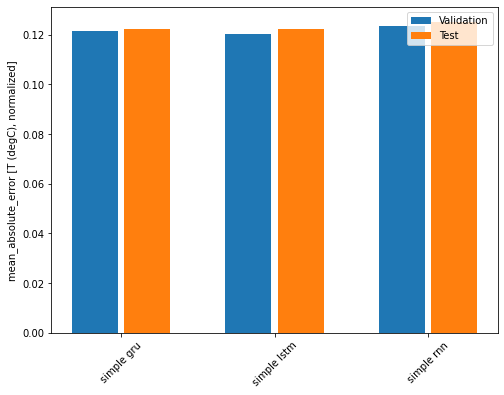

In [62]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = simple_rnn.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()